In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/classification short video")

Mounted at /content/drive


In [15]:
!gdown 1H7ZxxYCFhEgVLAu4aN_u-afSJbVqrMFZ

Downloading...
From (original): https://drive.google.com/uc?id=1H7ZxxYCFhEgVLAu4aN_u-afSJbVqrMFZ
From (redirected): https://drive.google.com/uc?id=1H7ZxxYCFhEgVLAu4aN_u-afSJbVqrMFZ&confirm=t&uuid=ba3ae9fb-9c95-446a-9649-c20124194f56
To: /content/drive/MyDrive/Colab Notebooks/classification short video/val_dataset.pickle
100% 864M/864M [00:14<00:00, 60.6MB/s]


In [17]:
!mv ./val_dataset.pickle ./dataset/val_dataset.pickle

### 1. Import module

In [18]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import io
import torch.nn as nn
import os
import pandas as pd
import cv2
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torchvision import transforms
import gc

### Load the dataset

#### function load video

In [19]:
def load_video(path, max_frame=100, size=(480,480)):
    capture = cv2.VideoCapture(path)
    all_frames = []
    while True:
        ret, frame = capture.read()
        if len(all_frames) == max_frame:
            break
        if not ret:
            break
        frame = get_center_square(frame)
        frame = cv2.resize(frame,size)
        frame = frame[:, :, [2,1,0]] # ảnh đọc ra bởi cv2 ở dạng BGR, chuyển về RGB
        frame = torch.tensor(frame)
        frame = frame.permute(2,0,1) # chuyển về channel, height, width
        all_frames.append(frame)
    capture.release()
    return torch.stack(all_frames, dim=0) # dim = (100, 3, size[0], size[1])


"""Get center square of frame"""
def get_center_square(frame):
    y, x = frame.shape[0:2]
    min_lenght = min(x,y)
    start_x = (x//2) - min_lenght//2
    start_y = (y//2) - min_lenght//2
    frame = frame[start_y : start_y + min_lenght, start_x : start_x + min_lenght]
    return frame

#### Create dataframe

In [20]:
def create_dataframe_metadata(df, start, end, label_encoder=None, encode_label=None):
    df_punch = df[df['tag'] == 'Punch']
    df_playCello = df[df['tag'] == 'PlayingCello']
    df_CricketShot = df[df['tag'] == 'CricketShot']
    df_ShavingBeard = df[df['tag'] == 'ShavingBeard']
    df_TennisSwing = df[df['tag'] == 'TennisSwing']
    new_df = pd.concat([df_punch[start:end], df_playCello[start:end], df_CricketShot[start:end], df_ShavingBeard[start:end], df_TennisSwing[start:end]], ignore_index=True)
    new_df['origin_tag'] = new_df['tag']
    if label_encoder is not None:
        new_df['tag'] = label_encoder.fit_transform(new_df['tag'])
    else:
        new_df['tag'] = new_df['tag'].map(encode_label)
    return new_df

In [21]:
folder_path_train = "./video_data/train/"
folder_path_test = "./video_data/test/"

train_df = pd.read_csv("./video_data/train.csv")
test_df = pd.read_csv("./video_data/test.csv")

In [22]:
print(train_df['tag'].value_counts())
print(test_df['tag'].value_counts())

tag
Punch           121
PlayingCello    120
CricketShot     118
ShavingBeard    118
TennisSwing     117
Name: count, dtype: int64
tag
CricketShot     49
TennisSwing     49
PlayingCello    44
ShavingBeard    43
Punch           39
Name: count, dtype: int64


In [23]:
label_encoder = LabelEncoder()

In [24]:
df_train = create_dataframe_metadata(train_df, 0, 90, label_encoder=label_encoder)
df_train

,video_name,tag,origin_tag
0,v_Punch_g08_c01.avi,2,Punch
1,v_Punch_g08_c02.avi,2,Punch
2,v_Punch_g08_c03.avi,2,Punch
3,v_Punch_g08_c04.avi,2,Punch
4,v_Punch_g08_c05.avi,2,Punch
...,...,...,...
445,v_TennisSwing_g20_c05.avi,4,TennisSwing
446,v_TennisSwing_g20_c06.avi,4,TennisSwing
447,v_TennisSwing_g21_c01.avi,4,TennisSwing
448,v_TennisSwing_g21_c02.avi,4,TennisSwing


In [25]:
decode_label = dict()
for index, row in df_train.iterrows():
    decode_label.update({row['tag']: row['origin_tag']})
encode_label = {v:k for k,v in decode_label.items()}

In [26]:
df_val = create_dataframe_metadata(train_df, 90, 110, encode_label=encode_label)
df_test = create_dataframe_metadata(test_df, 0, 50, encode_label=encode_label)
df_test

,video_name,tag,origin_tag
0,v_Punch_g01_c01.avi,2,Punch
1,v_Punch_g01_c02.avi,2,Punch
2,v_Punch_g01_c03.avi,2,Punch
3,v_Punch_g01_c04.avi,2,Punch
4,v_Punch_g01_c05.avi,2,Punch
...,...,...,...
219,v_TennisSwing_g07_c03.avi,4,TennisSwing
220,v_TennisSwing_g07_c04.avi,4,TennisSwing
221,v_TennisSwing_g07_c05.avi,4,TennisSwing
222,v_TennisSwing_g07_c06.avi,4,TennisSwing


#### Augumentation dataset

In [27]:
def augmentation_picture(frame):
    transform_a_frame = transforms.Compose([
        # transforms.RandomRotation(degrees=(90,90)), # xoay ảnh 90 90
        transforms.GaussianBlur(kernel_size=11, sigma=1), # làm mờ ảnh nhẹ với vùng ảnh là 11x11
        transforms.RandomErasing(scale=(0.01, 0.1), ratio=(1, 1)) # scale là phạm vi tỷ lệ (min, max) cho vùng xóa so với ảnh ban đầu, ratio là tỉ lệ chiều rộng và cao
    ])
    result = transform_a_frame(frame)
    return result

def augmentation_video(frames):
    new_frames = []
    for frame in frames:
        new_frame = augmentation_picture(frame)
        new_frames.append(new_frame)
    return torch.stack(new_frames,dim=0)

#### Create dataset

In [28]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, img_size=(120,120), all_labels=[], is_train=True):
        self.video_paths = video_paths
        self.img_size = img_size
        self.all_labels = all_labels
        self.new_labels = []
        self.is_train = is_train
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.new_labels[index]

    def load_data(self):
        data = []

        for index, path in tqdm(enumerate(self.video_paths)):
            frames = load_video(path, size=self.img_size)
            self.new_labels.append(self.all_labels[index])
            data.append(frames)

            if self.is_train:
                new_frames = augmentation_video(frames)
                data.append(new_frames)
                self.new_labels.append(self.all_labels[index])
        return pad_sequence(data, batch_first=True, padding_value=0)




In [29]:
all_label_train = list(df_train['tag'])
all_label_val = list(df_val['tag'])

In [30]:
train_paths = [os.path.join(folder_path_train, i) for i in df_train['video_name']]
test_paths = [os.path.join(folder_path_test, i) for i in df_test['video_name']]
val_paths = [os.path.join(folder_path_train, i) for i in df_val['video_name']]

In [31]:
load_video(train_paths[10])[0].shape # channel, height, width

torch.Size([3, 480, 480])

100


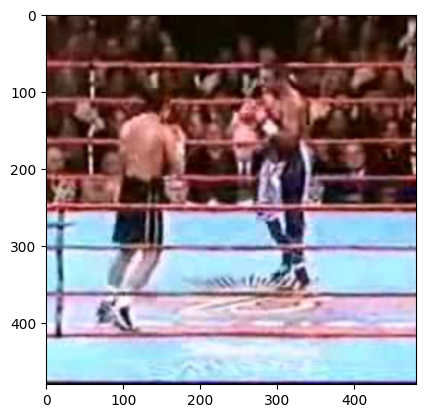

In [32]:
vid0_frame = load_video(val_paths[10])
print(len(vid0_frame))
img_plot_test = vid0_frame[0].permute(1,2,0).numpy() # chuyển về height, width, channel để plot ảnh (224,224,3)
plt.imshow(img_plot_test)

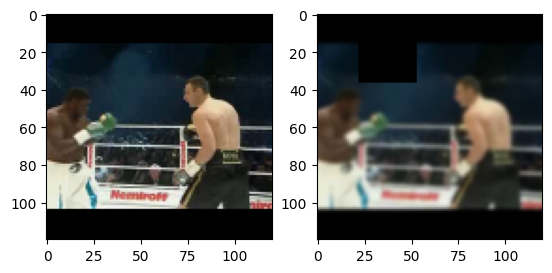

In [33]:
test_augment_path = train_paths[20]
frames_before = load_video(test_augment_path, size=(120,120))
frames_after = augmentation_video(frames_before)

img_after_augment = frames_after[0].permute(1,2,0).numpy()
img_before_augment = frames_before[0].permute(1,2,0).numpy()
fig_aug, ax_aug = plt.subplots(1,2)
ax_aug[0].imshow(img_before_augment)
ax_aug[1].imshow(img_after_augment)

In [34]:
# train_dataset = VideoDataset(train_paths, all_labels= all_label_train)
# val_dataset = VideoDataset(val_paths, all_labels= all_label_val)
# test_dataset = VideoDataset(test_paths, all_labels= list(df_test['tag']), is_train=False)

In [35]:
# frames, label = train_dataset.__getitem__(100)
# print(decode_label[label])
# plt.imshow(frames[0].permute(1,2,0).numpy())

#### save & load dataset

In [36]:
import pickle

def save_dataset(dataset, path):
    with open(path, 'wb') as f:
        pickle.dump(dataset, f)

def load_dataset(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [ ]:
# save_dataset(train_dataset, "./dataset/train_dataset.pickle")
# save_dataset(val_dataset, "./dataset/val_dataset.pickle")
# save_dataset(test_dataset, "./dataset/test_dataset.pickle")

In [37]:
train_dataset = load_dataset("./dataset/train_dataset.pickle")
val_dataset = load_dataset("./dataset/val_dataset.pickle")
test_dataset = load_dataset("./dataset/test_dataset.pickle")

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model

#### get pretrained

In [39]:
def get_cnn_pretrained(model:str = 'resnet50' or 'resnet101' or 'resnet152'):
    if model=='resnet50':
      CNN_pretrained = torchvision.models.resnet50(pretrained = True)
    elif model=='resnet101':
      CNN_pretrained = torchvision.models.resnet101(pretrained = True)
    else:
      CNN_pretrained = torchvision.models.resnet152(pretrained = True)
    CNN_pretrained = torch.nn.Sequential(*list(CNN_pretrained.children())[:8])
    return CNN_pretrained

In [40]:
sample_frames, sample_label = next(iter(val_dataloader))
print(decode_label[int(sample_label[0])])
sample_frames.shape

Punch


torch.Size([32, 100, 3, 120, 120])

In [41]:
Resnet50 = get_cnn_pretrained('resnet50')
Resnet101 = get_cnn_pretrained('resnet101')
Resnet152 = get_cnn_pretrained('resnet152')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [42]:
output_test = Resnet50(sample_frames[:,1].float())
output_test.shape

torch.Size([32, 2048, 4, 4])

In [43]:
output_test = Resnet101(sample_frames[:,1].float())
output_test.shape

torch.Size([32, 2048, 4, 4])

#### CNN-RNN Model

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [49]:
class LSTM(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(LSTM, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            hidden = torch.zeros((self.batch_size, self.hidden_size))
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.lstm(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res[0])

        return x

In [50]:
class RNN(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(RNN, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.rnn = nn.RNN(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.rnn(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res)

        return x

In [51]:
# Thêm patience và delta vào EarlyStopping
class EarlyStopping:
    def __init__(self, path_to_save, delta = 0.01, patience = 3, restore_best_weights=True):
        '''
        delta là tham số kiểm soát độ dao động của loss, loss ở các epoch đầu được phép dao dộng lớn hơn loss ở các epoch về sau
        patience là số lượng epoch mà loss không giảm thì sẽ dừng train
        restore_best_weights là lựa chọn có restore lại weight tốt nhất hay không
        '''
        self.best_val_loss_average = np.inf
        self.best_val_loss = np.inf
        self.path_to_save = path_to_save
        self.early_stop = False
        self.delta = delta
        self.patience = patience
        self.counter = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def __call__(self, current_average_loss_val, current_loss_val,model):
        if current_average_loss_val < self.best_val_loss_average:
            print(f"loss validation average decrease from {self.best_val_loss_average} to {current_average_loss_val}, Saving checkpoint...")
            self.best_val_loss_average = current_average_loss_val
            self.best_val_loss = current_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_loss_val < self.best_val_loss:
            print(f"loss validation decrease from {self.best_val_loss} to {current_loss_val}, Saving checkpoint...")
            self.best_val_loss = current_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_average_loss_val < self.best_val_loss_average + self.delta*self.best_val_loss_average:
            print(f"loss validation average slightly increased from {self.best_val_loss_average} to {current_average_loss_val}, No save! ")
            self.counter += 1
        else:
            self.counter += 1
            print(f"No improvement. Early stopping counter: {self.counter}/{self.patience}")

        # Nếu counter >= patience thì dừng train
        if self.counter >= self.patience:
            print("Early stopping")
            self.early_stop = True
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
                print("Restore best weights")


### Train

#### trainer

In [52]:
class Trainer:
    def __init__(self, dataloader_train, dataloader_val, model, optimizer, criterion, epochs=1, scheduler=None):
        self.dataloader_train = dataloader_train
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloader_val = dataloader_val
        self.history_average_train_loss = []
        self.history_average_train_acc = []
        self.history_average_val_loss = []
        self.history_average_val_acc = []
        self.history_train_acc = []
        self.epoch_after_early_stop = 1
        self.early_stop_epoch = 0

        # Thêm scheduler
        self.scheduler = scheduler
    def val(self, model_val, device):
        torch.cuda.empty_cache()
        pbar_val = tqdm(self.dataloader_val)
        total_val = 0
        total_correct_val = 0
        all_loss_vall_current = []
        all_acc_vall_current = []
        last_loss_val = np.inf
        for a, b in pbar_val:
            a = a.to(device)
            b = b.to(device)
            out = model_val(a)
            out = out.to(device)
            criterion_val = self.criterion
            loss_val = criterion_val(out, b)
            all_loss_vall_current.append(loss_val.cpu().detach().numpy())
            total_correct_val += (torch.argmax(out, dim=1) == b).sum().item()
            total_val += b.size(0)
            acc_val = total_correct_val/total_val
            all_acc_vall_current.append(acc_val)
            last_loss_val = loss_val
            pbar_val.set_description(f'Acc_val: {acc_val} loss_val {loss_val}')
        loss_val_average = np.average(all_loss_vall_current)
        self.history_average_val_loss.append(loss_val_average)
        self.history_average_val_acc.append(np.average(all_acc_vall_current))
        return loss_val_average, last_loss_val

    def train(self, path_to_save):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model
        model.to(device)
        optimizer = self.optimizer
        criterion = self.criterion
        early_stopping = EarlyStopping( path_to_save, delta=0.1)
        index_after_early_stop = 0
        for epoch in range(self.epochs):
            model.train()
            current_loss_train = []
            current_acc_train = []
            pbar = tqdm(self.dataloader_train)
            total = 0
            total_correct = 0
            print(optimizer.param_groups[0]['lr'])
            for X, y in pbar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                X = X.to(device)
                y = y.to(device)
                yh = model(X)
                yh = yh.to(device)
                total_correct += (torch.argmax(yh, dim=1) == y).sum().item()
                total += y.size(0)
                acc = total_correct/total
                loss = criterion(yh, y)
                '''
                Với criterion là CrossEntropyLoss thì thứ tự là output trc rồi đến target
                    vì hàm này yêu cầu chiều của output là (batch_size x class) còn chiều của target là (batch_size)
                '''
                current_loss_train.append(loss.item())
                current_acc_train.append(acc)
                self.history_train_acc.append(acc)
                loss.backward()
                optimizer.step()
                pbar.set_description(f'Epoch: {epoch} Loss: {loss.item()}, Acc: {acc}')
            self.history_average_train_loss.append(np.average(current_loss_train))
            self.history_average_train_acc.append(np.average(current_acc_train))
            current_average_loss_val, current_loss_val = self.val(model.eval(), device)

            # Thêm scheduler.step
            if self.scheduler:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(current_average_loss_val)  # Với ReduceLROnPlateau
                    print(f"Learning rate hiện tại: {optimizer.param_groups[0]['lr']}")

            print(f"current_average_loss_val: {current_average_loss_val}")

            if early_stopping.early_stop:
                index_after_early_stop += 1
                print(f"epoch {index_after_early_stop} after early stop")
                if index_after_early_stop == self.epoch_after_early_stop:
                    break
                continue
            early_stopping.delta = 1 * (1/(epoch+1)) # điều chỉnh tham số delta theo epoch
            early_stopping(current_average_loss_val, current_loss_val ,model)
            if early_stopping.early_stop:
                print("\n early stop")
                self.early_stop_epoch = epoch

In [53]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def get_trainer(model):
    learning_rate = 1e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

    n_epochs = 100

    return Trainer(train_dataloader, val_dataloader, model, optimizer, criterion, n_epochs, scheduler)

In [54]:
import matplotlib.pyplot as plt

def get_plot(trainer, type, model_name):
    plt.title(model_name)

    if type == 'loss':
        plt.plot(trainer.history_average_train_loss, label='train loss')
        plt.plot(trainer.history_average_val_loss, label='val loss')
    else:
        plt.plot(trainer.history_average_train_acc, label='train acc')
        plt.plot(trainer.history_average_val_acc, label='val acc')
    plt.axvline(trainer.early_stop_epoch - 3, color='r', linestyle='--', label='early stop')
    plt.legend()
    plt.show()

#### config

In [55]:
HIDDEN_SIZE = 512
NUM_CLASSES = 5
BATCH_SIZE = 32

In [56]:
# model = LSTM(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE) # thay đổi batch_size nhớ thay cả ở chỗ này
model_resnet50 = RNN(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)
model_resnet101 = RNN(Resnet101, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)
model_resnet152 = RNN(Resnet152, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)

In [57]:
test_output = model_resnet50(sample_frames.to(device))
test_output

tensor([[ 0.5655,  0.4349,  0.3586,  0.0616,  0.1177],
        [ 0.4891,  0.0894,  0.1039, -0.4216, -0.2780],
        [ 0.4458,  0.1696,  0.4174, -0.2262,  0.0156],
        [-0.2784,  0.0566,  0.3734, -0.1246,  0.1979],
        [ 0.1716, -0.0341,  0.4781, -0.0817, -0.3374],
        [ 0.0714,  0.0880,  0.2726, -0.3626, -0.0649],
        [ 0.4252, -0.0215,  0.4940, -0.2574,  0.1512],
        [-0.0506, -0.1750,  0.4388, -0.2816, -0.0807],
        [ 0.2584, -0.0423,  0.0897,  0.2184, -0.3240],
        [ 0.4764,  0.6873,  0.0411, -0.0443, -0.0305],
        [-0.0135,  0.1505,  0.1634, -0.3145, -0.0431],
        [ 0.5199,  0.0242,  0.0867, -0.8135,  0.1281],
        [ 0.1811, -0.0516,  0.3798, -0.1453, -0.1605],
        [ 0.3289,  0.1645,  0.0283, -0.1863, -0.3987],
        [-0.1381, -0.1139,  0.6800, -0.5939, -0.2020],
        [ 0.3846, -0.0347,  0.6170, -0.1063,  0.2475],
        [-0.0713,  0.2702,  0.4455, -0.0806,  0.3437],
        [ 0.1745, -0.1850, -0.2089,  0.1233, -0.2435],
        [ 

In [58]:
trainer_resnet50 = get_trainer(model_resnet50)
trainer_resnet101 = get_trainer(model_resnet101)
trainer_resnet152 = get_trainer(model_resnet152)

#### ResNet50

In [59]:
torch.cuda.empty_cache()
trainer_resnet50.train("model50-rnn_checkpoint.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.715 loss_val 1.1504786014556885: 100%|██████████| 7/7 [00:19<00:00,  2.83s/it]


current_average_loss_val: 0.9500870108604431
loss validation average decrease from inf to 0.9500870108604431, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.755 loss_val 0.8366624712944031: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


current_average_loss_val: 0.6966498494148254
loss validation average decrease from 0.9500870108604431 to 0.6966498494148254, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.81 loss_val 0.5807913541793823: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


current_average_loss_val: 0.5587599873542786
loss validation average decrease from 0.6966498494148254 to 0.5587599873542786, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.81 loss_val 0.41420912742614746: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


current_average_loss_val: 0.5596749186515808
loss validation decrease from 0.5807913541793823 to 0.41420912742614746, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.75 loss_val 1.1750843524932861: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


current_average_loss_val: 0.7470832467079163
No improvement. Early stopping counter: 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.85 loss_val 0.5919451713562012: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


current_average_loss_val: 0.4863164722919464
loss validation average decrease from 0.5587599873542786 to 0.4863164722919464, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.82 loss_val 1.2383902072906494: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


current_average_loss_val: 0.570077657699585
No improvement. Early stopping counter: 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 7 Loss: 0.024692239239811897, Acc: 0.96375: 100%|██████████| 25/25 [01:23<00:00,  3.36s/it]
Acc_val: 0.73 loss_val 0.6153721809387207: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


current_average_loss_val: 0.6690044403076172
No improvement. Early stopping counter: 2/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.825 loss_val 0.43797412514686584: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


current_average_loss_val: 0.4950237572193146
loss validation decrease from 0.5919451713562012 to 0.43797412514686584, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.855 loss_val 0.13502398133277893: 100%|██████████| 7/7 [00:19<00:00,  2.83s/it]


current_average_loss_val: 0.43044260144233704
loss validation average decrease from 0.4863164722919464 to 0.43044260144233704, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.76 loss_val 1.5228089094161987: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


current_average_loss_val: 0.7112236618995667
No improvement. Early stopping counter: 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 11 Loss: 0.10373744368553162, Acc: 0.96375: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it]
Acc_val: 0.72 loss_val 0.7606555819511414: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


current_average_loss_val: 0.7360273003578186
No improvement. Early stopping counter: 2/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.815 loss_val 0.7622500658035278: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


current_average_loss_val: 0.5277897119522095
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.785 loss_val 0.772854208946228: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]

current_average_loss_val: 0.6131026148796082
epoch 1 after early stop


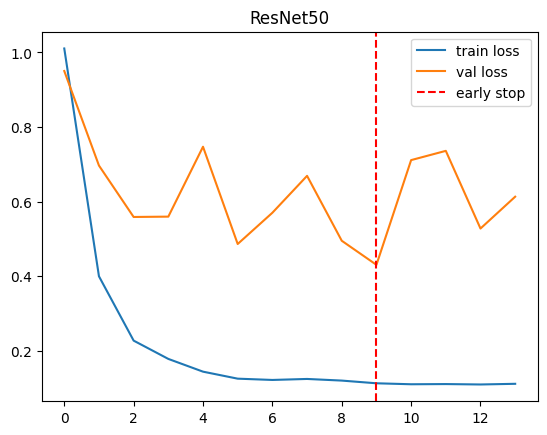

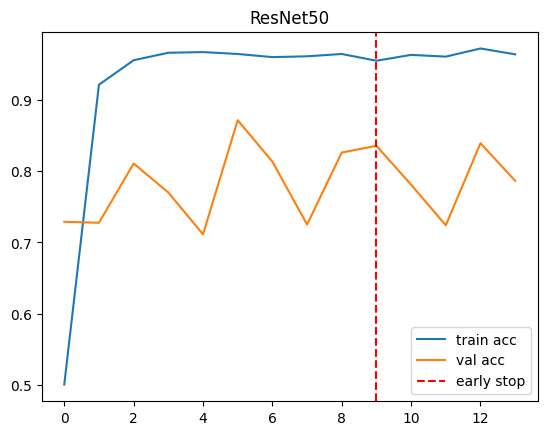

In [60]:
get_plot(trainer_resnet50, "loss", "ResNet50")
get_plot(trainer_resnet50, "acc", "ResNet50")

#### Resnet101

In [65]:
torch.cuda.empty_cache()
trainer_resnet101.train("model101-rnn_checkpoint.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.765 loss_val 0.9795047640800476: 100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


current_average_loss_val: 0.9313093423843384
loss validation average decrease from inf to 0.9313093423843384, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.795 loss_val 0.14882218837738037: 100%|██████████| 7/7 [00:32<00:00,  4.65s/it]


current_average_loss_val: 0.6036725044250488
loss validation average decrease from 0.9313093423843384 to 0.6036725044250488, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 2 Loss: 0.062004461884498596, Acc: 0.95375: 100%|██████████| 25/25 [02:15<00:00,  5.43s/it]
Acc_val: 0.795 loss_val 0.5714560747146606: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it]


current_average_loss_val: 0.5670045614242554
loss validation average decrease from 0.6036725044250488 to 0.5670045614242554, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.83 loss_val 0.5142917037010193: 100%|██████████| 7/7 [00:32<00:00,  4.61s/it]


current_average_loss_val: 0.4967289865016937
loss validation average decrease from 0.5670045614242554 to 0.4967289865016937, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.81 loss_val 0.5012307167053223: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it]


current_average_loss_val: 0.5347544550895691
loss validation decrease from 0.5142917037010193 to 0.5012307167053223, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.77 loss_val 1.0383822917938232: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it]


current_average_loss_val: 0.6836571097373962
No improvement. Early stopping counter: 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.83 loss_val 0.7491797208786011: 100%|██████████| 7/7 [00:32<00:00,  4.62s/it]


current_average_loss_val: 0.5108070373535156
loss validation average slightly increased from 0.4967289865016937 to 0.5108070373535156, No save! 


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.79 loss_val 0.06251809746026993: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it]


current_average_loss_val: 0.5481947064399719
loss validation decrease from 0.5012307167053223 to 0.06251809746026993, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.82 loss_val 0.04358787462115288: 100%|██████████| 7/7 [00:32<00:00,  4.60s/it]


current_average_loss_val: 0.4683585464954376
loss validation average decrease from 0.4967289865016937 to 0.4683585464954376, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.785 loss_val 0.3276940584182739: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it]


current_average_loss_val: 0.5956416726112366
No improvement. Early stopping counter: 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 10 Loss: 0.21946407854557037, Acc: 0.96375: 100%|██████████| 25/25 [02:14<00:00,  5.39s/it]
Acc_val: 0.845 loss_val 0.10267113149166107: 100%|██████████| 7/7 [00:32<00:00,  4.61s/it]


current_average_loss_val: 0.4275074899196625
loss validation average decrease from 0.4683585464954376 to 0.4275074899196625, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 11 Loss: 0.07648484408855438, Acc: 0.96375: 100%|██████████| 25/25 [02:15<00:00,  5.42s/it]
Acc_val: 0.805 loss_val 0.7570056319236755: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it]


current_average_loss_val: 0.5954402089118958
No improvement. Early stopping counter: 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 12 Loss: 0.10124494135379791, Acc: 0.96375: 100%|██████████| 25/25 [02:15<00:00,  5.41s/it]
Acc_val: 0.83 loss_val 0.5779005289077759: 100%|██████████| 7/7 [00:32<00:00,  4.61s/it]


current_average_loss_val: 0.4904075264930725
No improvement. Early stopping counter: 2/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.805 loss_val 0.30394214391708374: 100%|██████████| 7/7 [00:32<00:00,  4.60s/it]


current_average_loss_val: 0.5389729738235474
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 14 Loss: 0.11204738169908524, Acc: 0.96375: 100%|██████████| 25/25 [02:15<00:00,  5.41s/it]
Acc_val: 0.82 loss_val 0.11435049027204514: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it]

current_average_loss_val: 0.5262882113456726
epoch 1 after early stop


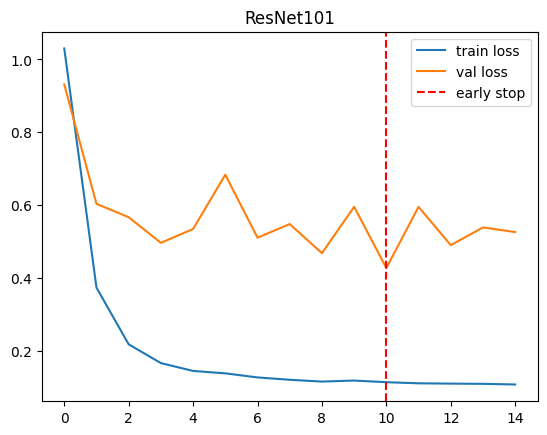

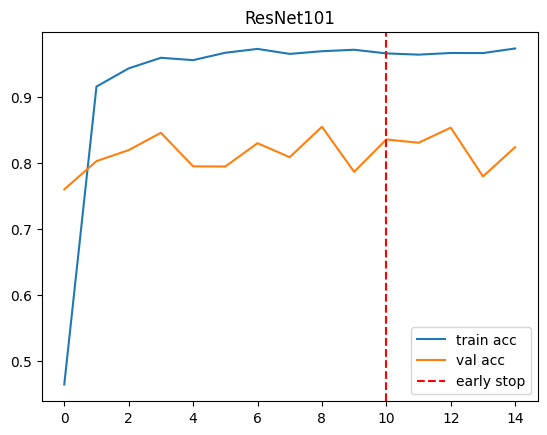

In [66]:
get_plot(trainer_resnet101, "loss", "ResNet101")
get_plot(trainer_resnet101, "acc", "ResNet101")

#### Resnet152

In [69]:
torch.cuda.empty_cache()
trainer_resnet152.train("model152-rnn_checkpoint.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.7 loss_val 0.780310869216919: 100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


current_average_loss_val: 0.9215905070304871
loss validation average decrease from inf to 0.9215905070304871, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.79 loss_val 0.4948475956916809: 100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


current_average_loss_val: 0.5748447179794312
loss validation average decrease from 0.9215905070304871 to 0.5748447179794312, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.765 loss_val 0.64404296875: 100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


current_average_loss_val: 0.6158695220947266
loss validation average slightly increased from 0.5748447179794312 to 0.6158695220947266, No save! 


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.845 loss_val 0.617539644241333: 100%|██████████| 7/7 [00:45<00:00,  6.45s/it]


current_average_loss_val: 0.48593196272850037
loss validation average decrease from 0.5748447179794312 to 0.48593196272850037, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.765 loss_val 0.9079544544219971: 100%|██████████| 7/7 [00:45<00:00,  6.56s/it]


current_average_loss_val: 0.6221427917480469
No improvement. Early stopping counter: 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 5 Loss: 0.041925542056560516, Acc: 0.96125: 100%|██████████| 25/25 [03:08<00:00,  7.53s/it]
Acc_val: 0.81 loss_val 0.26399463415145874: 100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


current_average_loss_val: 0.4834391474723816
loss validation average decrease from 0.48593196272850037 to 0.4834391474723816, Saving checkpoint...


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.785 loss_val 0.7024901509284973: 100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


current_average_loss_val: 0.6286351084709167
No improvement. Early stopping counter: 1/3


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Epoch: 7 Loss: 0.042904969304800034, Acc: 0.96375: 100%|██████████| 25/25 [03:08<00:00,  7.54s/it]
Acc_val: 0.805 loss_val 0.3755987584590912: 100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


current_average_loss_val: 0.5283212065696716
loss validation average slightly increased from 0.4834391474723816 to 0.5283212065696716, No save! 


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.79 loss_val 0.2918599545955658: 100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


current_average_loss_val: 0.5724992156028748
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/25 [00:00<?, ?it/s]

0.0001


Acc_val: 0.735 loss_val 0.5093856453895569: 100%|██████████| 7/7 [00:45<00:00,  6.46s/it]

current_average_loss_val: 0.6743130087852478
epoch 1 after early stop


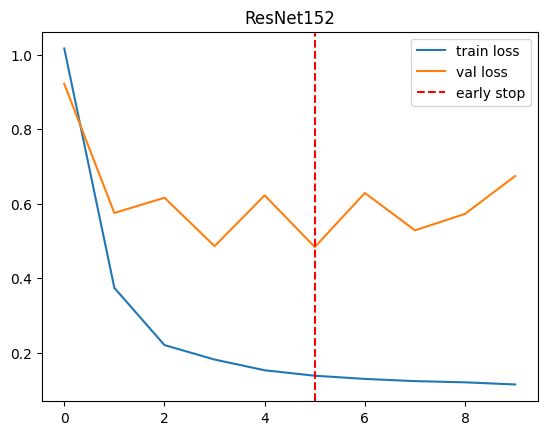

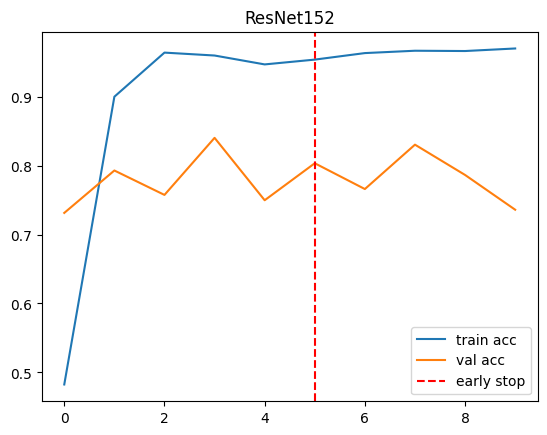

In [72]:
get_plot(trainer_resnet152, "loss", "ResNet152")
get_plot(trainer_resnet152, "acc", "ResNet152")

### Test

In [63]:
class Tester:
    def __init__(self, model, dataloader_test):
        self.dataloader_test = dataloader_test
        self.model = model
    def test(self):
        torch.cuda.empty_cache()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_test = self.model
        model_test.to(device)
        pbar_test = tqdm(self.dataloader_test)
        total_test = 0
        total_correct_test = 0
        for a, b in pbar_test:
            a = a.to(device)
            b = b.to(device)
            out = model_test(a)
            total_correct_test += (torch.argmax(out, dim=1) == b).sum().item()
            total_test += b.size(0)
            acc_test = total_correct_test/total_test
            pbar_test.set_description(f'Acc_test: {acc_test}')

### Test with resnet50

In [61]:
# model_save = LSTM(CNNPretrained, 512, 5, 8)
model_resnet50_save = RNN(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet50_save.load_state_dict(torch.load("./model50-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [64]:
test_resnet50 = Tester(model_resnet50_save, test_dataloader)
test_resnet50.test()

Acc_test: 0.71875: 100%|██████████| 7/7 [00:21<00:00,  3.12s/it]


#### Test with resnet101

In [67]:
# model_save = LSTM(CNNPretrained, 512, 5, 8)
model_resnet101_save = RNN(Resnet101, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet101_save.load_state_dict(torch.load("./model101-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [68]:
test_resnet101 = Tester(model_resnet101_save, test_dataloader)
test_resnet101.test()

Acc_test: 0.7723214285714286: 100%|██████████| 7/7 [00:35<00:00,  5.06s/it]


#### Test with resnet152

In [70]:
# model_save = LSTM(CNNPretrained, 512, 5, 8)
model_resnet152_save = RNN(Resnet152, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet152_save.load_state_dict(torch.load("./model152-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [71]:
test_resnet152 = Tester(model_resnet152_save, test_dataloader)
test_resnet152.test()

Acc_test: 0.75: 100%|██████████| 7/7 [00:50<00:00,  7.15s/it]
